In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger
import warnings
warnings.simplefilter("ignore")

Using TensorFlow backend.


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
GOOGLE_COLAB = True
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
TEST_FILE = "test_file.txt"
MODEL_FILE = "model.h5"

In [4]:
if GOOGLE_COLAB:
    !pip install livelossplot
from livelossplot import PlotLossesKeras

In [5]:
# Data
path = ""
if GOOGLE_COLAB:
    from google.colab import drive, files
    drive.mount('/content/drive/')
    path = "/content/drive/My Drive/Data/"
training_data_dir = path + "training" # 10 000 * 2
validation_data_dir = path + "validation" # 2 500 * 2
test_data_dir = path + "test" # 12 500

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 25
BATCH_SIZE = 32
TEST_SIZE = 30
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

In [8]:
from keras.models import Model
import keras
from keras import regularizers
base_model= ResNet50(include_top=False, weights='imagenet',classes=2,input_shape=(224,224,3))
x = base_model.output
x=Flatten()(x)
# x=Dense(1024, activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)
# # x=keras.layers.BatchNormalization()(x)
# x=Dropout(0.5)(x)
x=Dense(512, activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)
# x=keras.layers.BatchNormalization()(x)
x=Dropout(0.5)(x)
x=Dense(256, activation='relu',kernel_regularizer=regularizers.l1(0.01))(x)
# x=keras.layers.BatchNormalization()(x)
x=Dropout(0.5)(x)
predictions=Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)








94658560/94653016 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# Data augmentation
training_data_generator = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_input,
    validation_split=0.2
    )
validation_data_generator = ImageDataGenerator(rescale=1./255,
                                              preprocessing_function=preprocess_input)
test_data_generator = ImageDataGenerator(rescale=1./255,
                                        preprocessing_function=preprocess_input)

In [10]:
# Data preparation
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training')

validation_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation') # set as validation data

# validation_generator = validation_data_generator.flow_from_directory(
#     validation_data_dir,
#     target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
#     batch_size=BATCH_SIZE,
#     class_mode='categorical',
#     shuffle=True)
test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode='categorical', 
    shuffle=False)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [11]:
import keras
adm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adm, metrics=['accuracy'])

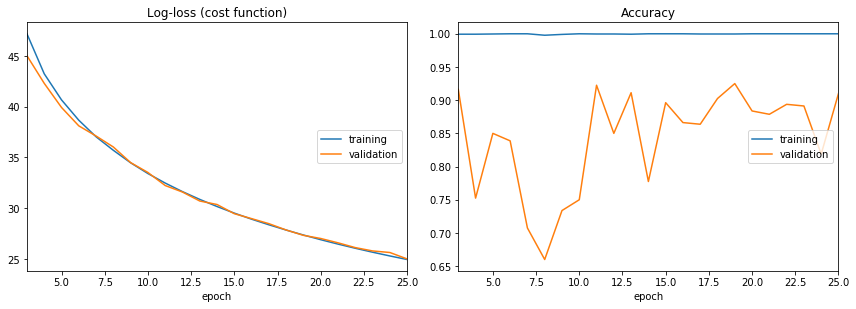

Log-loss (cost function):
training   (min:   24.940, max:  768.479, cur:   24.940)
validation (min:   24.998, max:  125.003, cur:   24.998)

Accuracy:
training   (min:    0.983, max:    1.000, cur:    1.000)
validation (min:    0.660, max:    0.959, cur:    0.910)


In [0]:
# Training
model.fit_generator(
    training_generator,
    steps_per_epoch=training_generator.n//training_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.n//validation_generator.batch_size,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)

In [0]:
# model.save_weights(MODEL_FILE)
model.save("testfinal2.h5")

In [0]:
# Testing
open(TEST_FILE,"w")
probabilities = model.predict_generator(test_generator, TEST_SIZE)

In [15]:
class_names = training_generator.class_indices.keys()
class_names

dict_keys(['heart', 'non_heart'])

In [0]:
predict=model.predict(test_generator)